# Importing Data

In [16]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
def readCreateDataframe(folder_path : Path, fake: bool = False) -> pd.DataFrame:
    if not folder_path.is_dir():
        raise ValueError("Folder path does not exist")
    data = []
    for file in sorted(folder_path.iterdir()):
        text = file.read_text()
        if fake:
            data.append([text, 1])
        else:
            data.append([text, 0])
    return pd.DataFrame(data, columns=["text", "label"])

In [3]:
df_fake = readCreateDataframe(Path("Data/full_texts/fake"), fake=True)
df_true = readCreateDataframe(Path("Data/full_texts/true"), fake=False)

In [4]:
df = pd.concat([df_fake, df_true], ignore_index=True)
df.reset_index(drop=True, inplace=True)
df = df.sample(frac=1, random_state=461249612).reset_index(drop=True) # to shuffle the data
df

text  label
0      © DPA Se chamar “Fátima” num país avesso ao q...      0
1     Esposa de Lula sofre AVC e está em estado grav...      1
2     Thiago Lacerda solta o verbo: "Artistas defend...      1
3     Barbosa : "Michel Temer não tem legitimidade p...      1
4     Barroso: "Criamos uma sociedade cheia de ricos...      1
...                                                 ...    ...
7195  Festejos ao Dois de Julho reúnem famílias e tê...      0
7196  Candidato Luiz Castro participa de entrevista ...      0
7197  BNDES e FRIBOI: Uma das famílias mais poderosa...      1
7198  Vaquinha virtual da Dona Dilma já conseguiu ar...      1
7199  Psiquiatra emite diagnóstico de Lula: "Persona...      1

[7200 rows x 2 columns]

In [5]:
del df_fake, df_true

# Tokenizing

We will use the BERTTokenizer from HiggingFace

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
input_ids = [tokenizer.encode(text, add_special_tokens=True, return_tensors='pt',  truncation=True, padding='max_length', max_length=512) for text in df.text]
input_ids

[tensor([[  101,  1075,  1040,  4502,  7367, 15775,  7849,  1523, 27596,  1524,
          16371,  2213,  6643,  2483, 13642, 24137, 20118, 10861,  1041,  1523,
           9765,  5521,  6806,  1524,  7110,  2850, 14736,  2015,  7367,  9686,
           3366,  1523,  9765,  5521,  6806,  1524, 14841,  6299,  1037,  2310,
           2099,  4012,  8529,  2050,  2128,  3669, 10440,  2080,  4830, 24209,
           2389,  1010, 18499,  8529, 14804,  2080,  1010,  7367,  7842,  4783,
          14163,  9956, 13433, 14194,  2080,  1010,  2139,  2041,  3217,  1041,
           3419,  8447, 18609,  1523, 10927,  2140,  1524,  1041,  1523,  4190,
          25090, 22911,  7113,  1524, 18499, 13675, 27605, 15460,  2891,  2061,
          17080, 12269,  1010, 17522,  4502, 10230, 10861,  9686, 25778, 29122,
           1051, 21045,  2080, 18609, 11503, 29344,  1041,  8529,  2566,  7389,
           9077,  1006, 11498,  4487,  6290, 20118,  7163,  5302,  1007,  1010,
          16137, 23233,  2050,  4012, 28

# Creating the Dataloader

In [7]:
y = df.label.tolist()
X_train, X_test, y_train, y_test = train_test_split(input_ids, y, test_size=0.2, random_state=461249612)

In [8]:
train_dataset = TensorDataset(torch.stack(X_train).squeeze(1), torch.tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [9]:
test_dataset = TensorDataset(torch.stack(X_test).squeeze(1), torch.tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# Training the model

In [10]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
from tqdm import tqdm

num_epochs = 5
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
model.train()
avg_loss_list = []

for epoch in range(num_epochs):
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}')
    
    for batch in progress_bar:
        # Move batch to GPU
        input_ids = batch[0].to(device)
        labels = batch[1].to(device)
        
        # Zero out gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids, labels=labels)
        loss = outputs.loss
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Update progress bar
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{total_loss/(progress_bar.n+1):.4f}'})
    
    avg_loss = total_loss / len(train_dataloader)
    avg_loss_list.append(avg_loss)
    print(f'\nEpoch {epoch + 1} - Average Loss: {avg_loss:.4f}')

Epoch 1: 100%|██████████| 720/720 [08:25<00:00,  1.42it/s, loss=0.2230]



Epoch 1 - Average Loss: 0.2230


Epoch 2: 100%|██████████| 720/720 [08:35<00:00,  1.40it/s, loss=0.1239]



Epoch 2 - Average Loss: 0.1239


Epoch 3: 100%|██████████| 720/720 [08:34<00:00,  1.40it/s, loss=0.0567]



Epoch 3 - Average Loss: 0.0567


Epoch 4: 100%|██████████| 720/720 [08:34<00:00,  1.40it/s, loss=0.0361]



Epoch 4 - Average Loss: 0.0361


Epoch 5: 100%|██████████| 720/720 [08:32<00:00,  1.41it/s, loss=0.0226]


Epoch 5 - Average Loss: 0.0226


Text(0, 0.5, 'Average Loss')

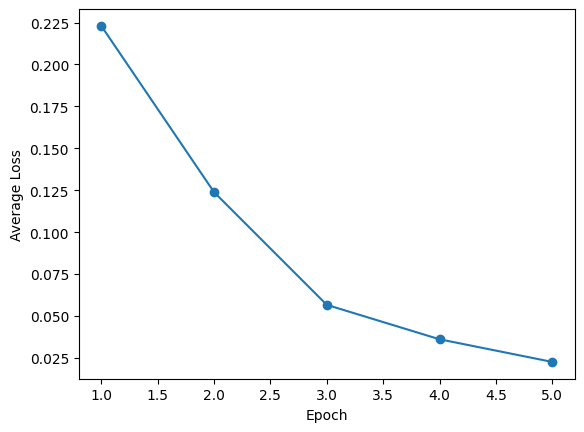

In [20]:
plt.plot(np.arange(1,6,1),avg_loss_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')

In [14]:
model.save_pretrained("BERT_retrained")

# Testing the Results

In [15]:
model = BertForSequenceClassification.from_pretrained("BERT_retrained")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model.eval()

y_true = []
y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(input_ids, labels=labels)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        y_true.extend(labels.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())

In [21]:
report = classification_report(y_true, y_pred, target_names=["Fake", "Real"])
print(report)   

              precision    recall  f1-score   support

        Fake       0.99      0.95      0.97       716
        Real       0.96      0.99      0.97       724

    accuracy                           0.97      1440
   macro avg       0.98      0.97      0.97      1440
weighted avg       0.98      0.97      0.97      1440

